# 贝叶斯向量自回归

**发布日期**: 2019年10月15日

**文章作者**: Xinyu Chen (陈新宇) [[GitHub主页](https://github.com/xinychen)]

**下载**: 本Jupyter Notebook可在GitHub仓库[GraphicalML](https://github.com/mobility-computing/GrapicalML/blob/master/content/bvar.ipynb)中下载和使用。


## 0 关于本文

- 讨论贝叶斯向量自回归模型的形式
- 介绍如何实现贝叶斯向量自回归
- 分析贝叶斯向量自回归的应用

## 1 向量自回归模型

向量自回归模型的英文名称为Vector Autoregressive model，常被简写成VAR。向量自回归的出现由来已久，可以追溯到上个世纪80年代，人们构建向量自回归模型主要出于以下考虑：

- 时间序列分析从单一时间序列 (time series data) 拓展到了多元时间序列 (multivariate time series)，在任意第$t$个时间间隔 (time interval)，观测样本从1变成了$N$，其中，$N$表示多元时间序列中时间序列的数量。
- 标准的自回归模型 (Autoregressive model, 简称AR) 其表达式过于简单，无法很好地在多元时间序列分析中发挥作用。


### 1.1 标准的自回归模型

在统计学、经济学乃至信号处理等领域，自回归模型被广泛应用于描述随时间变化的过程 (简称时变过程)，其中，最为经典的应用当属时间序列分析，在这里，自回归模型假设变量之间存在一个线性的依赖关系，即输出变量 (output variables) 如$y_t$与输入的历史变量 (previous variables) 如$y_{t-1},y_{t-2},...$存在一个线性表达式。

不妨先看一下标准的自回归模型：给定单一时间序列$\boldsymbol{y}\in\mathbb{R}^{T}$，其时间间隔的数量为$T$，则对于任意第$t$个时间间隔，存在如下的线性表达式：
\begin{equation}
y_{t}=\sum_{k=1}^{d}a_ky_{t-k}+\epsilon_t,~t=d+1,...,T,
\end{equation}
其中，$a_k,k=1,2,...,d$表示回归系数；常数$d$表示自回归模型的阶数 (order)，也可以将$d$简单地理解成当前时间点关联过去时间点的数量。

在自回归模型中，我们的目标是从观测数据中学习出参数$a_k,k=1,...,d$。现假设观测数据为$\boldsymbol{y}\in\mathbb{R}^{T}$，首先，我们需要对自回归模型的线性表达式进行改写：
\begin{equation}
\begin{aligned}
&y_{t}\approx\boldsymbol{a}^\top{\boldsymbol{v}}_{t},~t=d+1,...,T, \\
\Rightarrow&\boldsymbol{z}\approx Q\boldsymbol{a},
\end{aligned}
\end{equation}
其中，${\boldsymbol{v}}_{t}=\left(y_{t-1},y_{t-2},...,y_{t-d}\right)\in\mathbb{R}^{d}$；$\boldsymbol{z}=\left(y_{d+1},y_{d+2},...,y_{T}\right)\in\mathbb{R}^{T-d}$；$Q=\left[\begin{array}{c}{\boldsymbol{v}_{d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{v}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-d) \times d}$. 在这里，写成这种形式完全是为了简化后续的推导。

如果进一步将$\epsilon_t$作为高斯噪声，采用最小二乘法，则回归系数$\boldsymbol{a}$的最优解为
\begin{equation}
\begin{aligned}
\boldsymbol{a}&=\text{arg}\min_{\boldsymbol{x}}~\frac{1}{2}\sum_{t=d+1}^{T}\left(y_{t}-\boldsymbol{x}^\top{\boldsymbol{v}}_{t}\right)^2 \\
&=\text{arg}\min_{\boldsymbol{x}}~\frac{1}{2}\left(\boldsymbol{z}-Q\boldsymbol{x}\right)^\top\left(\boldsymbol{z}-Q\boldsymbol{x}\right) \\
&=\text{arg}\min_{\boldsymbol{x}}~\frac{1}{2}\left(\boldsymbol{x}^\top Q^\top Q\boldsymbol{x}-\boldsymbol{z}^\top Q\boldsymbol{x}-\boldsymbol{x}^\top Q^\top\boldsymbol{z}\right) \\
&=\left(Q^\top Q\right)^{-1}Q^\top\boldsymbol{z}. \\
\end{aligned}
\end{equation}


这里采用最小二乘法实际上能极大程度上简化算法的实现过程，无需迭代，只需要输入相应的变量$\boldsymbol{y}$和阶数$d$就可以根据回归系数$\boldsymbol{a}$的最优解进行计算。

In [ ]:
import numpy as np

def ar_model(vec_y, order_d):
    """
    用Numpy实现自回归模型AR(d).
    输入变量1：时间序列向量vec_y；
    输入变量2：自回归模型阶数order_d，取正整数，如1, 2, 3, ..., n.
    输出变量：自回归模型的系数vec_a.
    """
    
    T = vec_y.shape[0]
    time_lags = np.array(list(range(1, order_d + 1)))
    vec_z = vec_y[order_d :] # 定义向量z
    mat_Q = np.zeros((T - order_d, order_d)) # 定义矩阵Q
    for t in range(T - order_d):
        mat_Q[t, :] = vec_y[t + order_d - time_lags]
    
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(mat_Q.T, mat_Q)), mat_Q.T), vec_z)

### 1.2 多元时间序列

实际上，相比单一的时间序列数据，多元时间序列数据反而更为常见，是由单一的时间序列构成，如下面的矩阵
\begin{equation}
Y=\left[\begin{array}{ccccc}
y_{11} & \cdots & y_{1t} & \cdots & y_{1T} \\
y_{21} & \cdots & y_{2t} & \cdots & y_{2T} \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
y_{N1} & \cdots & y_{Nt} & \cdots & y_{NT} \\
\end{array}
\right]\in\mathbb{R}^{N\times T}
\end{equation}
就是一般形式的多元时间序列数据。在矩阵$Y$中，任意第$t$个时间间隔下，观测值为
\begin{equation}
\boldsymbol{y}_{t}=\left(y_{1t},y_{2t},...,y_{Nt}\right)^\top\in\mathbb{R}^{N},
\end{equation}
观测值的数量为$N$.

### 1.3 向量自回归模型

针对多元时间序列数据，向量自回归模型采用了一种更为灵活的时序建模策略：给定多元时间序列数据为$Y\in\mathbb{R}^{N\times T}$，则对于任意第$t$个时间间隔，存在如下的线性表达式：
\begin{equation}
\boldsymbol{y}_{t}=\sum_{k=1}^{d}A_k\boldsymbol{y}_{t-k}+\boldsymbol{\epsilon}_{t},~t=d+1,...,T,
\end{equation}
其中，$A_k\in\mathbb{R}^{N\times N},k=1,2,...,d$表示向量自回归模型的系数矩阵；$\boldsymbol{\epsilon}_t$可视为高斯噪声。

为方便后续推导，与自回归模型类似，令
\begin{equation}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} \in \mathbb{R}^{(N d) \times N}, \quad \boldsymbol{v}_{t}=\left[\begin{array}{c}{\boldsymbol{y}_{t-{1}}} \\ {\vdots} \\ {\boldsymbol{y}_{t-{d}}}\end{array}\right] \in \mathbb{R}^{(N d)},
\end{equation}
将向量自回归模型进行改写：
\begin{equation}
\begin{aligned}
\boldsymbol{y}_{t}&\approx \sum_{k=1}^{d}A_k\boldsymbol{y}_{t-k}, \\
&=A^\top\boldsymbol{v}_{t},~t=d+1,...,T, \\
\Rightarrow Z&\approx QA, \\
\end{aligned}
\end{equation}
其中，公式中的矩阵$Z$和$Q$定义如下：
\begin{equation}
Z=\left[\begin{array}{c}{\boldsymbol{y}_{{d}+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{y}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{\left(T-{d}\right) \times N}, \quad Q=\left[\begin{array}{c}{\boldsymbol{v}_{{d}+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{v}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-d) \times(N d)}.
\end{equation}

由此，采用最小二乘法，系数矩阵$A$的最优解为
\begin{equation}
\begin{aligned}
A&=\text{arg}\min_{X}~\frac{1}{2}\left\|Z-QX\right\|_{F}^{2} \\
&=\text{arg}\min_{X}~\frac{1}{2}\text{tr}\left(\left(Z-QX\right)^\top\left(Z-QX\right)\right) \\
&=\text{arg}\min_{X}~\frac{1}{2}\text{tr}\left(X^\top Q^\top QX-Z^\top QX-X^\top Q^\top Z\right) \\
&=\left(Q^\top Q\right)^{-1}Q^\top Z. \\
\end{aligned}
\end{equation}

> 在这里，我们用到了F-范数与矩阵迹 (trace) 之间的等价变换，它的意义是为了方便推导，如何简单理解这种等价变换呢？举一个例子：给定任意大小为$2\times 2$的矩阵$$A=\left[\begin{array}{cc} a_{11} & a_{12} \\ a_{21} & a_{22} \\ \end{array}\right]\in\mathbb{R}^{2\times 2},$$由于F-范数是矩阵所有元素的平方和开根号，即$$\|A\|_{F}=\left(a_{11}^{2}+a_{12}^{2}+a_{21}^{2}+a_{22}^{2}\right)^{\frac{1}{2}},$$另外，$$A^\top A=\left[\begin{array}{cc} a_{11}^2+a_{21}^2 & a_{11}a_{12}+a_{21}a_{22} \\ a_{12}a_{11}+a_{22}a_{21} & a_{12}^{2}+a_{22}^{2} \\ \end{array}\right],$$因此，根据矩阵迹的定义，有$$\text{tr}\left(A^\top A\right)=a_{11}^{2}+a_{12}^{2}+a_{21}^{2}+a_{22}^{2}=\|A\|_{F}^2.$$



与自回归模型的求解过程类似，这里采用最小二乘法也能极大程度上简化算法的实现过程，无需迭代，只需要输入相应的变量$Y$和阶数$d$就可以根据系数矩阵$A$的最优解进行计算。

In [1]:
import numpy as np

def var_model(mat_Y, order_d, num_pred):
    """
    用Numpy实现向量自回归模型VAR(d).
    输入变量1：多元时间序列矩阵mat_Y；
    输入变量2：自回归模型阶数order_d，取正整数，如1, 2, 3, ..., n；
    输入变量3：自回归模型的预测长度num_pred.
    输出变量1：自回归模型的系数mat_A；
    输出变量2：自回归模型的预测值mat_Y_new[:, T:].
    """
    
    N, T = mat_Y.shape
    time_lags = np.array(list(range(1, order_d + 1)))
    mat_Z = mat_Y[:, order_d :].T # 定义矩阵Z
    mat_Q = np.zeros((T - order_d, N * order_d)) # 定义矩阵Q
    for t in range(T - order_d):
        mat_Q[t, :] = mat_Y[:, t + order_d - time_lags].reshape([N * order_d])
    mat_A = np.matmul(np.matmul(np.linalg.inv(np.matmul(mat_Q.T, mat_Q)), mat_Q.T), mat_Z) # 计算系数矩阵A
    mat_Y_new = np.zeros((N, T + num_pred))
    mat_Y_new[:, : T] = mat_Y
    for t in range(num_pred):
        mat_Y_new[:, t + T] = np.matmul(mat_A.T, mat_Y_new[:, t + T - time_lags].reshape([N * order_d]))
    
    return mat_A, mat_Y_new[:, T :]

### 1.4 多元时间序列预测

当存在多个时间序列，且它们之间相互影响时，则向量自回归模型就可以作为分析这类数据的有效模型。

不过使用向量自回归模型时，我们还需要对参数数量有一个大概的了解。当多元时间序列数据是由$N$个单一时间序列构成时，若采用阶数为$d$的向量自回归模型，则参数数量为$N^2d$，或者写成$N\times (Nd)$；当用作训练的时间序列长度为$T$时，我们相当于拥有$N\times T$的观测样本用作参数估计 (学习)。在这里，如果采用最小二乘法对$N\times (Nd)$的参数进行估计，为了保证参数学习的有效性，在设置阶数$d$时需要满足：
$$Nd\ll T,$$
即观测样本数量要远大于模型参数数量。

<img src="../images/forecasting.png" alt="drawing" width="350"/>

> 时间序列预测问题（图片来源：https://multithreaded.stitchfix.com/blog/2017/02/28/whats-wrong-with-my-time-series/）。

#### 1) 广州城市路网车速数据集

**关于数据集**

- 由214条路段车速时间序列构成；
- 时间间隔共计$61\times 144=8784$.

**预测任务**

- 滚动预测最后5天$5\times 144=720$个时间间隔的时间序列；
- 单步滚动预测 (single-step rolling prediction)，每次滚动用到历史8周数据；
- 多步滚动预测 (multi-step rolling prediction)，每次滚动用到历史8周数据.

**参数设置**

- 对于单步滚动预测，阶数为$d=1,2,3,4,5$；
- 对于多步滚动预测，预测时间间隔为$2,3,4,5$，阶数为$d=1,2,3,4,5$.

**模型设置**

- 系数矩阵动态更新，即每次滚动重新估计系数矩阵，并计算相应的时间序列预测值。

**性能评估**

- MAPE (%),
- RMSE.

In [2]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
X = dense_mat # 大小为214-by-8784，数据集存在缺失数据，此处不作处理。

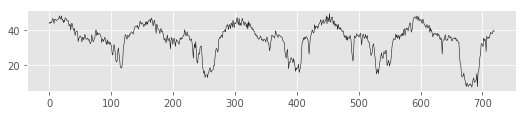

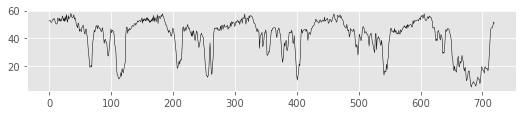

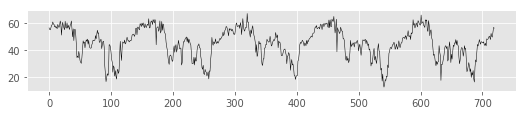

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
## 绘制前三条时间序列最后5天的时间序列数据：
for i in range(3):
    fig = plt.figure(figsize = (8, 1.5))
    ax = fig.add_axes([0.10, 0.22, 0.85, 0.75])
    plt.plot(X[i, 56 * 144 :], color = "black", linewidth = 0.5)
    plt.show()

In [76]:
import time
start = time.time()

order_d = 20
N = X.shape[0]
pred_steps = 144 * 5
back_steps = 144 * 7 * 8
num_pred = 144
start_step = X.shape[1] - pred_steps
mat_hat = np.zeros((N, pred_steps))
for t in range(int(pred_steps / num_pred)):
    if t == 0:
        A, vec = var_model(X[:, 0 : t * num_pred + start_step], order_d, num_pred)
    else:
        A, vec = var_model(X[:, t * num_pred + start_step - back_steps 
                             : t * num_pred + start_step], order_d, num_pred)
    if num_pred == 1:
        mat_hat[:, t] = vec.reshape(N)
    else:
        mat_hat[:, t * num_pred : (t + 1) * num_pred] = vec
    if (t + 1) % 40 == 0:
        print('The current prediction step is {}.'.format(t + 1))

end = time.time()
print('Running time: %d seconds'%(end - start))

Running time: 43 seconds


In [77]:
mat = X[:, start_step : X.shape[1]]
mat0 = X[:, X.shape[0] - pred_steps - 1 : X.shape[0] - 1]
pos = np.where(mat != 0)
print('MAPE: {}'.format(np.sum(np.abs(mat[pos] - mat_hat[pos])/mat[pos])/mat[pos].shape[0]))
print('RMSE: {}'.format(np.sqrt(np.sum((mat[pos] - mat_hat[pos]) ** 2)/mat[pos].shape[0])))

MAPE: 0.16948262957368235
RMSE: 6.195235305226982


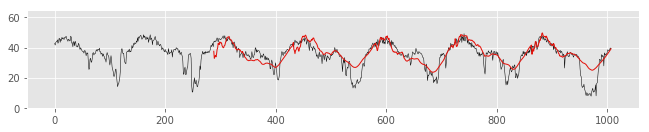

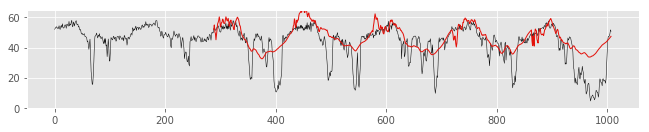

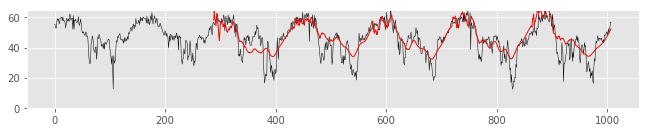

In [78]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
for i in range(3):
    fig = plt.figure(figsize = (10, 2))
    ax = fig.add_axes([0.13, 0.28, 0.85, 0.68])
    plt.plot(X[i, 54 * 144 :], color = "black", linewidth = 0.5)
    plt.plot(list(range(X.shape[1] - pred_steps - 54 * 144, X.shape[1] - 54 * 144)), 
             mat_hat[i, :], color = "#e3120b", linewidth = 1.0)
    ax.set_ylim([0, 65])

**单步滚动预测结果** (MAPE/RMSE)

|     阶数    |    $d=1$    |    $d=2$    |    $d=3$    |    $d=4$    |    $d=5$    |
|:-----------|------------:|------------:|------------:|------------:|------------:|
|`num_pred`=1|  7.22/3.10  |  7.30/3.14  |  7.41/3.17  |  7.52/3.21  |  7.65/3.25  |

结果分析：对于单步滚动预测，当阶数$d$增大时，预测效果会逐渐变差，最佳的阶数为$d=1$。

**多步滚动预测结果** (MAPE/RMSE)

|      阶数     |    $d=1$    |    $d=2$    |    $d=3$    |    $d=4$    |    $d=5$    |
|:-------------|------------:|------------:|------------:|------------:|------------:|
|`num_pred`=2  |  8.27/3.54  |  8.36/3.61  |  8.46/3.65  |  8.57/3.67  |  8.71/3.71  |
|`num_pred`=3  |  9.05/3.88  |  9.14/3.98  |  9.21/4.01  |  9.33/4.04  |  9.45/4.07  |
|`num_pred`=4  |  9.51/3.96  |  9.53/3.94  |  9.60/3.98  |  9.70/4.01  |  9.84/4.06  |
|`num_pred`=5  | 10.06/4.18  | 10.06/4.15  | 10.08/4.16  | 10.16/4.18  | 10.29/4.24  |
|`num_pred`=144| 23.77/8.32  | 22.61/7.96  | 21.40/7.57  | 20.67/7.34  | 20.24/7.21  |

结果分析：当预测的时间间隔很小时，VAR(1)便能取得最佳的预测结果；随着预测的时间间隔增大，最佳的阶数也会随之增大，例如，预测未来5个时间间隔的时间序列时，VAR(2)取得最佳的预测结果，效果优于VAR(1)。

#### 2) 杭州地铁客流量数据集

**关于数据集**

- 由80个地铁站的入站客流量时间序列构成；
- 时间间隔为10分钟，共计$25\times 108=2700$个 (24:00至6:00之间不在服务时间，已经剔除25天中的该时段数据，因此，每天的时间间隔个数为108)。

**预测任务**

- 滚动预测最后5天$5\times 108=540$个时间间隔的时间序列；
- 单步滚动预测 (single-step rolling prediction)，每次滚动用到历史2周数据；
- 多步滚动预测 (multi-step rolling prediction)，每次滚动用到历史2周数据.

**参数设置**

- 对于单步滚动预测，阶数为$d=1,2,3,4,5$；
- 对于多步滚动预测，预测时间间隔为$2,3,4,5$，阶数为$d=1,2,3,4,5$.

**模型设置**

- 系数矩阵动态更新，即每次滚动重新估计系数矩阵，并计算相应的时间序列预测值。

**性能评估**

- MAPE (%),
- RMSE.

In [3]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
X = dense_mat # 大小为80-by-2700，数据集不存在缺失数据

In [69]:
import time
start = time.time()

order_d = 3
N = X.shape[0]
pred_steps = 108 * 5
back_steps = 108 * 7 * 2
num_pred = 5
start_step = X.shape[1] - pred_steps
mat_hat = np.zeros((N, pred_steps))
for t in range(int(pred_steps/num_pred)):
    if t == 0:
        A, vec = var_model(X[:, 0 : t * num_pred + start_step], order_d, num_pred)
    else:
        A, vec = var_model(X[:, t * num_pred + start_step - back_steps 
                             : t * num_pred + start_step], order_d, num_pred)
    if num_pred == 1:
        mat_hat[:, t] = vec.reshape(N)
    else:
        mat_hat[:, t * num_pred : (t + 1) * num_pred] = vec
    if (t + 1) % 40 == 0:
        print('The current prediction step is {}.'.format(t + 1))

end = time.time()
print('Running time: %d seconds'%(end - start))

The current prediction step is 40.
The current prediction step is 80.
Running time: 1 seconds


In [70]:
mat = X[:, start_step : X.shape[1]]
mat0 = X[:, X.shape[1] - pred_steps - 1 : X.shape[1] - 1]
pos = np.where(mat != 0)
print('MAPE: {}'.format(np.sum(np.abs(mat[pos] - mat_hat[pos])/mat[pos])/mat[pos].shape[0]))
print('RMSE: {}'.format(np.sqrt(np.sum((mat[pos] - mat_hat[pos]) ** 2)/mat[pos].shape[0])))

MAPE: 0.33951430128760296
RMSE: 39.68455364476149


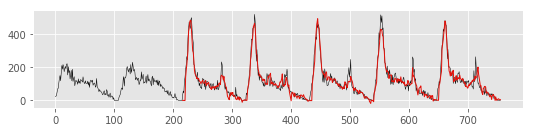

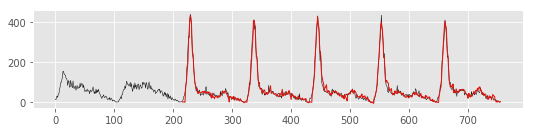

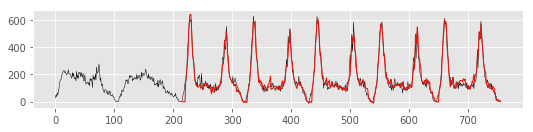

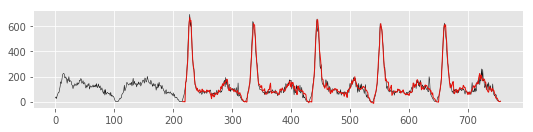

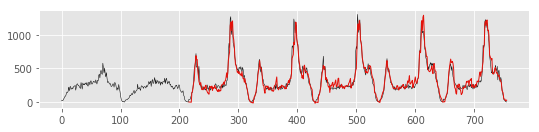

In [72]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
for i in range(5):
    fig = plt.figure(figsize = (8, 2))
    ax = fig.add_axes([0.13, 0.28, 0.85, 0.68])
    plt.plot(X[i, 18 * 108 :], color = "black", linewidth = 0.5)
    plt.plot(list(range(X.shape[1] - pred_steps - 18 * 108, X.shape[1] - 18 * 108)), 
             mat_hat[i, :], color = "#e3120b", linewidth = 1.0)

**单步滚动预测结果** (MAPE/RMSE)

|     阶数    |    $d=1$    |    $d=2$    |    $d=3$    |    $d=4$    |    $d=5$    |
|:-----------|------------:|------------:|------------:|------------:|------------:|
|`num_pred`=1| 23.55/33.98 | 24.26/32.56 | 24.49/32.12 | 25.62/32.64 | 27.68/33.39 |

结果分析：对于单步滚动预测，当阶数$d$增大时，预测效果会逐渐变差，从MAPE指标来看，最佳的阶数为$d=1$；从RMSE指标来看，最佳的阶数为$d=3$。

**多步滚动预测结果** (MAPE/RMSE)

|      阶数     |    $d=1$    |    $d=2$    |    $d=3$    |    $d=4$    |    $d=5$    |
|:-------------|------------:|------------:|------------:|------------:|------------:|
|`num_pred`=2  | 26.26/37.09 | 26.26/35.10 | 26.47/34.27 | 27.73/34.56 | 29.80/35.14 |
|`num_pred`=3  | 29.22/39.19 | 28.48/36.41 | 28.66/35.76 | 29.45/36.11 | 31.89/36.70 |
|`num_pred`=4  | 34.09/42.71 | 33.01/39.65 | 31.77/38.36 | 32.15/38.40 | 35.49/38.88 |
|`num_pred`=5  | 36.86/44.32 | 34.85/40.19 | 33.95/39.68 | 34.31/39.71 | 37.02/40.34 |

结果分析：预测的时间间隔越长，需要的阶数则往往越大，但阶数并非越大越好，过大会进一步导致预测效果变差。

## 2 贝叶斯向量自回归

对于向量自回归模型而言，不管采用怎样的求解方法，其求解过程中都会伴随着一定数量的待估计参数，因此，将向量自回归模型用于大规模多元时间序列数据时，为避免参数估计出现过拟合现象，对参数设置先验分布不失为一种有效的策略。除此之外，包括Gibbs采样在内的众多贝叶斯推断算法既能提供有效的参数估计，同时又能刻画参数估计值的不确定性 (uncertainty)。

### 2.1 回顾向量自回归模型

针对多元时间序列数据，向量自回归模型采用了一种灵活的时序建模策略：给定多元时间序列数据为$Y\in\mathbb{R}^{N\times T}$，则对于任意第$t$个时间间隔，存在如下的线性表达式：
\begin{equation}
\boldsymbol{y}_{t}=\sum_{k=1}^{d}A_k\boldsymbol{y}_{t-k}+\boldsymbol{\epsilon}_{t},~t=d+1,...,T,
\end{equation}
其中，$A_k\in\mathbb{R}^{N\times N},k=1,2,...,d$表示向量自回归模型的系数矩阵；$\boldsymbol{\epsilon}_t$可视为高斯噪声。

令
\begin{equation}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} \in \mathbb{R}^{(N d) \times N}, \quad \boldsymbol{v}_{t}=\left[\begin{array}{c}{\boldsymbol{y}_{t-{1}}} \\ {\vdots} \\ {\boldsymbol{y}_{t-{d}}}\end{array}\right] \in \mathbb{R}^{(N d)},
\end{equation}
将向量自回归模型进行改写：
\begin{equation}
\begin{aligned}
\boldsymbol{y}_{t}&\approx \sum_{k=1}^{d}A_k\boldsymbol{y}_{t-k}, \\
&=A^\top\boldsymbol{v}_{t},~t=d+1,...,T, \\
\Rightarrow Z&\approx QA, \\
\end{aligned}
\end{equation}
其中，公式中的矩阵$Z$和$Q$定义如下：
\begin{equation}
Z=\left[\begin{array}{c}{\boldsymbol{y}_{{d}+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{y}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{\left(T-{d}\right) \times N}, \quad Q=\left[\begin{array}{c}{\boldsymbol{v}_{{d}+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{v}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-d) \times(N d)}.
\end{equation}



### 2.2 矩阵正态分布

在众多统计分布中，正态分布 (高斯分布) 是我们的很早就接触到的概率分布，将其形式用于以向量为随机变量$\boldsymbol{x} \in \mathbb{R}^{m}$，便形成了我们在线性代数、概率论等相关课程中学到的多元正态分布 (multivariate normal distribution)，其概率密度函数为

\begin{equation}
\begin{aligned}
&\mathcal{N}(\boldsymbol{x} | \boldsymbol{\mu}, \Sigma)=(2 \pi)^{-m / 2}|\Sigma|^{-1 / 2} \exp \left(-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^{\top} \Sigma^{-1}(\boldsymbol{x}-\boldsymbol{\mu})\right) \\ =&(2 \pi)^{-m / 2}|\Sigma|^{-1 / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left[(\boldsymbol{x}-\boldsymbol{\mu})(\boldsymbol{x}-\boldsymbol{\mu})^{\top} \Sigma^{-1}\right]\right) \\
\end{aligned}
\end{equation}
其中，$\boldsymbol{\mu} \in \mathbb{R}^{m}$表示多元正态分布的均值向量；$\Sigma$则表示协方差矩阵。

需要说明的是，这里将多元正态分布的指数项写成矩阵迹 (trace) 的形式是为了方面后续认识矩阵正态分布，其中，在多元正态分布的写法中，$(\boldsymbol{x}-\boldsymbol{\mu})^{\top} \Sigma^{-1}(\boldsymbol{x}-\boldsymbol{\mu})=\operatorname{tr}\left[(\boldsymbol{x}-\boldsymbol{\mu})(\boldsymbol{x}-\boldsymbol{\mu})^{\top} \Sigma^{-1}\right]$是恒成立的。

在多元正态分布的基础上，实际上还存在一种正态分布，它是以矩阵为随机变量，若随机矩阵$X\in\mathbb{R}^{m\times n}$服从矩阵正态分布，则其概率密度函数为

\begin{equation}
\begin{aligned}
&\mathcal{M} \mathcal{N}_{m \times n}(X | M, U, V) \\ =&(2 \pi)^{-m n / 2}|V|^{-m / 2}|U|^{-n / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left[V^{-1}(X-M)^{\top} U^{-1}(X-M)\right]\right)
\end{aligned}
\end{equation}
其中，符号$\mathcal{M N}_{m \times n}(\cdot)$来自于矩阵正态分布 (matrix normal distribution) 英文首字母的简写，下标指代随机矩阵的大小；矩阵$M \in \mathbb{R}^{m \times n}$，与随机矩阵$X$大小相同，对应于均值项；矩阵$U \in \mathbb{R}^{m \times m}$、$V \in \mathbb{R}^{n \times n}$对应于协方差矩阵。

> 注：关于矩阵正态分布更为详细的介绍可参考[统计学习 | 矩阵正态分布 (matrix normal distribution)
](https://zhuanlan.zhihu.com/p/73585133)。

### 2.3 贝叶斯向量自回归模型

### 2.4 参数的后验分布与Gibbs采样

In [164]:
import numpy as np
from numpy.linalg import inv as inv
from scipy.stats import invwishart
from scipy.stats import wishart
from numpy.random import multivariate_normal as mvnrnd

In [165]:
def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.rand(dim1, dim2)
    P = np.linalg.cholesky(U)
    Q = np.linalg.cholesky(V)
    return M + np.matmul(np.matmul(P, X0), Q.T)

In [166]:
def sampling_MNIW(mat_Z, mat_Q, M0, Psi0, S0, nu0):
    
    var_Psi = inv(inv(Psi0) + np.matmul(mat_Q.T, mat_Q)) # 后验参数Psi
    var_M = np.matmul(var_Psi, np.matmul(inv(Psi0), M0) + np.matmul(mat_Q.T, mat_Z)) # 后验参数M
    var_S = (S0 + np.matmul(mat_Z.T, mat_Z)# + np.matmul(np.matmul(M0.T, inv(Psi0)), M0)
             - np.matmul(np.matmul(var_M.T, inv(var_Psi)), var_M)) # 后验参数S
    var_nu = nu0 + mat_Z.shape[0] # 后验参数nu
    Sigma = invwishart(df = var_nu, scale = var_S, seed = None).rvs() # 用inv-Wishart后验分布对Sigma采样
    mat_A = mnrnd(var_M, var_Psi, Sigma) # 用matrix norm distribution后验分布对系数矩阵A采样
    return Sigma, mat_A

In [229]:
def bvar_model(mat_Y, mat_Y_new, order_d, num_pred, num_rolling, burn_iter, gibbs_iter):
    """
    用Numpy实现贝叶斯向量自回归模型BVAR(d).
    输入变量1：多元时间序列矩阵mat_Y；
    输入变量2：滚动预测输入矩阵mat_Y_new；
    输入变量3：自回归模型阶数order_d，取正整数，如1, 2, 3, ..., n；
    输入变量4：自回归模型的预测长度num_pred；
    输入变量5：自回归模型的滚动预测次数num_rolling；
    输入变量6：Gibbs采样的燃烧期迭代次数burn_iter；
    输入变量7：Gibbs采样的采样迭代次数gibbs_iter.
    输出变量1：自回归模型的系数mat_A；
    输出变量2：自回归模型的预测值mat_Y_new[:, T:].
    """
    
    N, T = mat_Y.shape
    time_lags = np.array(list(range(1, order_d + 1)))
    mat_Z = mat_Y[:, order_d :].T # 定义矩阵Z
    mat_Q = np.zeros((T - order_d, N * order_d)) # 定义矩阵Q
    for t in range(T - order_d):
        mat_Q[t, :] = mat_Z[t - time_lags, :].reshape([N * order_d])

    M0 = np.zeros((N * order_d, N))
    Psi0 = np.eye(N * order_d)
    S0 = np.eye(N)
    nu0 = N
    result = [] # 保存各变量在各代中的Gibbs采样值
    result.append(np.zeros((N, num_rolling * num_pred, gibbs_iter))) # 保存多元时间序列的预测值
    result.append(np.zeros((N * order_d, N, gibbs_iter))) # 保存系数矩阵A的采样值
    
    for it in range(burn_iter + gibbs_iter):
        Sigma, mat_A = sampling_MNIW(mat_Z, mat_Q, M0, Psi0, S0, nu0)
        if it >= burn_iter:
            for t0 in range(num_rolling):
                if t0 >= 1:
                    mat_Z_new = np.append(mat_Z, mat_Y_new[:, (t0 - 1) * num_pred : t0 * num_pred].T, axis = 0)
                    mat_Q_new = np.append(mat_Q, np.zeros((num_pred, N * order_d)), axis = 0)
                    for tt in range(num_pred):
                        mat_Q_new[tt - num_pred, :] = mat_Z_new[tt - num_pred - time_lags].reshape([N * order_d])
                    mat_Z = mat_Z_new.copy()
                    mat_Q = mat_Q_new.copy()
                result[1][:, :, it - burn_iter] = mat_A
                for t in range(num_pred):
                    if t == 0:
                        mat_Q_sample = mat_Q.copy()
                    else:
                        mat_Q_sample = np.append(mat_Q_sample, vec.reshape([1, N * order_d]), axis = 0)
                    vec0 = mvnrnd(np.matmul(mat_A.T, mat_Q_sample[t0 * num_pred + t + T - order_d - 1, :]), Sigma)
                    result[0][:, t0 * num_pred + t, it - burn_iter] = vec0
                    vec = np.append(vec0, mat_Q_sample[-1, N :])
        if (it + 1) % 100 == 0:
            print(it + 1)
    
    return result

### 2.5 多元时间序列预测

In [230]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
max_const = np.max(dense_mat)
X = dense_mat / max_const # 大小为80-by-2700，数据集不存在缺失数据

In [232]:
import time
start = time.time()

order_d = 2
pred_steps = 108 * 5
back_steps = 108 * 7 * 2
num_pred = 5
num_rolling = int(pred_steps / num_pred)
burn_iter = 1000
gibbs_iter = 100

start_step = X.shape[1] - pred_steps
mat_Y = X[:, 0 : start_step]
mat_Y_new = X[:, start_step : start_step + pred_steps - num_pred]
result = bvar_model(mat_Y, mat_Y_new, order_d, num_pred, num_rolling, burn_iter, gibbs_iter)

end = time.time()
print('Running time: %d seconds'%(end - start))

100
200
300
400
500
600
700
800
900
1000
1100
Running time: 4263 seconds


In [233]:
mat = X[:, start_step : X.shape[1]] * max_const
pos = np.where(mat != 0)
mat_hat = np.mean(result[0], axis = 2) * max_const
print('MAPE: {}'.format(np.sum(np.abs(mat[pos] - mat_hat[pos])/mat[pos])/mat[pos].shape[0]))
print('RMSE: {}'.format(np.sqrt(np.sum((mat[pos] - mat_hat[pos]) ** 2)/mat[pos].shape[0])))

MAPE: 0.371662520311232
RMSE: 44.300409121588196


In [234]:
mat_hat90 = np.percentile(result[0], 90, axis = 2)

In [237]:
import time
start = time.time()

order_d = 2
pred_steps = 108 * 5
back_steps = 108 * 7 * 2
num_pred = 5
num_rolling = int(pred_steps / num_pred)
burn_iter = 5000
gibbs_iter = 100

start_step = X.shape[1] - pred_steps
mat_Y = X[:, 0 : start_step]
mat_Y_new = X[:, start_step : start_step + pred_steps - num_pred]
result = bvar_model(mat_Y, mat_Y_new, order_d, num_pred, num_rolling, burn_iter, gibbs_iter)

end = time.time()
print('Running time: %d seconds'%(end - start))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
Running time: 2057 seconds


In [239]:
mat = X[:, start_step : X.shape[1]] * max_const
pos = np.where(mat != 0)
mat_hat = np.mean(result[0], axis = 2) * max_const
print('MAPE: {}'.format(np.sum(np.abs(mat[pos] - mat_hat[pos])/mat[pos])/mat[pos].shape[0]))
print('RMSE: {}'.format(np.sqrt(np.sum((mat[pos] - mat_hat[pos]) ** 2)/mat[pos].shape[0])))

MAPE: 0.37405811145984663
RMSE: 44.15142376552828


In [240]:
mat_hat10 = np.percentile(result[0], 10, axis = 2)
mat_hat90 = np.percentile(result[0], 90, axis = 2)

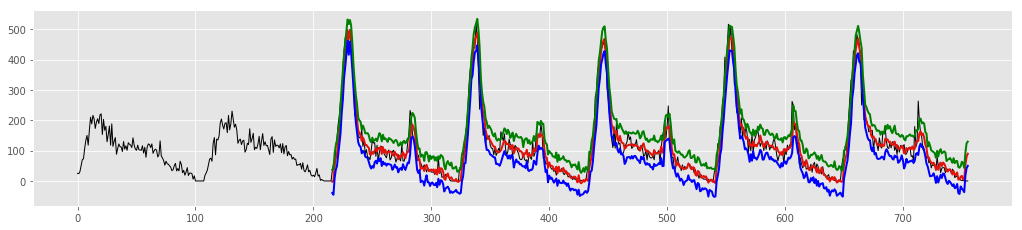

In [241]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
figsize = 2
for i in range(1):
    fig = plt.figure(figsize = (8 * figsize, 2 * figsize))
    ax = fig.add_axes([0.13, 0.28, 0.85, 0.68])
    plt.plot(X[i, 18 * 108 :] * max_const, color = "black", linewidth = 1)
    plt.plot(list(range(X.shape[1] - pred_steps - 18 * 108, X.shape[1] - 18 * 108)), 
             mat_hat[i, :], color = "#e3120b", linewidth = 2.0)
    plt.plot(list(range(X.shape[1] - pred_steps - 18 * 108, X.shape[1] - 18 * 108)), 
             mat_hat10[i, :] * max_const, color = "blue", linewidth = 2.0)
    plt.plot(list(range(X.shape[1] - pred_steps - 18 * 108, X.shape[1] - 18 * 108)), 
             mat_hat90[i, :] * max_const, color = "green", linewidth = 2.0)